# Comprehensive Ablation Studies for 5D Optimal Transport

This notebook performs systematic ablation studies:
1. Balanced OT (no epsilon, no splatting) - vary lambda, compute displacement fields
2. Vary rho for lambda = 2.0
3. Vary epsilon and select epsilon = 0.01
4. With epsilon = 0.01 and lambda = 2.0, vary rho and select rho = 0.7
5. Vary splatting with all parameter combinations

In [ ]:
import torch
import torch.nn.functional as F
from geomloss import SamplesLoss
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional, Tuple
from tqdm import tqdm
from pathlib import Path
import json
import os

In [ ]:
# --- Configuration ---

@dataclass
class OTConfig:
    """Configuration for 5D Optimal Transport."""
    resolution: tuple[int] = (64, 64)
    blur: float = 0.01
    scaling: float = 0.9
    reach: Optional[float] = None  # None = Balanced OT
    lambda_color: float = 2.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    sigma: Optional[float] = None  # None = no splatting, otherwise fixed sigma value

In [ ]:
# --- Utility Functions ---

def get_5d_cloud(img: torch.Tensor, res: int, lambda_c: float):
    """
    Convert image (C, H, W) to 5D point cloud (N, 5).
    Dimensions: [x, y, lambda*r, lambda*g, lambda*b]
    """
    C, H, W = img.shape
    
    # Downsampling
    scale = res / max(H, W)
    new_H, new_W = int(H * scale), int(W * scale)
    if new_H != H or new_W != W:
        img = F.interpolate(
            img.unsqueeze(0), size=(new_H, new_W), mode="bilinear"
        ).squeeze(0)
    
    # Normalized coordinates (x, y) in [0, 1]
    y = torch.linspace(0, 1, new_H, device=img.device)
    x = torch.linspace(0, 1, new_W, device=img.device)
    yy, xx = torch.meshgrid(y, x, indexing="ij")
    
    # (N, 2) spatial
    pos_spatial = torch.stack([xx, yy], dim=-1).reshape(-1, 2)
    
    # (N, 3) color
    colors = img.permute(1, 2, 0).reshape(-1, C)
    
    # 5D concatenation: [Space, Lambda * Color]
    cloud_5d = torch.cat([pos_spatial, lambda_c * colors], dim=-1)
    
    # Uniform masses
    N = cloud_5d.shape[0]
    weights = torch.ones(N, device=img.device) / N
    
    return cloud_5d, weights, colors, new_H, new_W

In [ ]:
def vectorized_gaussian_splatting(positions_2d, attributes, weights, H, W, sigma):
    """
    Vectorized Gaussian splatting (Nadaraya-Watson Kernel Regression).
    
    positions_2d : (N, 2) spatial coordinates in [0, 1]
    attributes   : (N, C) values to splat (RGB)
    weights      : (N,) particle masses
    sigma        : Gaussian kernel standard deviation (in pixels)
    
    Returns : (C, H, W) Reconstructed image
    """
    device = positions_2d.device
    N = positions_2d.shape[0]
    
    # Convert to pixel coordinates
    pos_pix = positions_2d * torch.tensor([W - 1, H - 1], device=device)
    
    # Kernel radius (3 sigma covers 99%)
    radius = int(np.ceil(3 * sigma))
    diameter = 2 * radius + 1
    
    # Local grid definition
    center_pix = torch.round(pos_pix).long()
    
    d_range = torch.arange(-radius, radius + 1, device=device)
    dy, dx = torch.meshgrid(d_range, d_range, indexing="ij")
    offsets = torch.stack([dx, dy], dim=-1).reshape(-1, 2)  # (K*K, 2)
    
    neighbor_coords = center_pix.unsqueeze(1) + offsets.unsqueeze(0)
    
    # Validity mask
    x_neigh = neighbor_coords[:, :, 0]
    y_neigh = neighbor_coords[:, :, 1]
    mask = (x_neigh >= 0) & (x_neigh < W) & (y_neigh >= 0) & (y_neigh < H)
    
    # Gaussian weights
    dist_sq = ((pos_pix.unsqueeze(1) - neighbor_coords.float()) ** 2).sum(dim=-1)
    gauss_weights = torch.exp(-dist_sq / (2 * sigma**2))
    
    contrib_weights = (gauss_weights * weights.unsqueeze(1)) * mask.float()
    
    # Accumulation
    flat_indices = y_neigh * W + x_neigh
    flat_indices = flat_indices.clamp(0, H * W - 1)
    
    # Denominator (weight accumulator)
    denom = torch.zeros(H * W, device=device)
    denom.scatter_add_(0, flat_indices.view(-1), contrib_weights.view(-1))
    
    # Numerator (color accumulator)
    C_channels = attributes.shape[1]
    weighted_attribs = attributes.unsqueeze(1) * contrib_weights.unsqueeze(-1)
    numer = torch.zeros(H * W, C_channels, device=device)
    
    for c in range(C_channels):
        val_c = weighted_attribs[:, :, c].view(-1)
        numer[:, c].scatter_add_(0, flat_indices.view(-1), val_c)
    
    # Normalization
    denom = denom.clamp(min=1e-6)
    out_img = numer / denom.unsqueeze(1)  # (H*W, C)
    out_img = out_img.reshape(H, W, C_channels).permute(2, 0, 1)  # (C, H, W)
    
    return out_img

In [ ]:
def compute_displacement_field(X_a, X_b, pi, H, W):
    """
    Compute displacement field from transport plan.
    
    Returns: (H, W, 2) displacement field
    """
    pos_a = X_a[:, :2]  # (N, 2)
    pos_b = X_b[:, :2]  # (M, 2)
    
    # Compute expected displacement for each source point
    # pi is (N, M), we want to compute sum_j pi_ij * (pos_b[j] - pos_a[i])
    N, M = pi.shape
    
    # Normalize transport plan row-wise to ensure proper probability distribution
    row_sums = pi.sum(dim=1, keepdim=True)
    # Handle rows with zero sum (degenerate case) - set to uniform distribution
    has_mass = row_sums > 1e-10
    pi_normalized = torch.where(
        has_mass,
        pi / (row_sums + 1e-10),
        torch.ones_like(pi) / M  # Uniform distribution if no mass
    )
    
    # Expand dimensions for broadcasting
    pos_a_expanded = pos_a.unsqueeze(1)  # (N, 1, 2)
    pos_b_expanded = pos_b.unsqueeze(0)  # (1, M, 2)
    
    # Displacements: (N, M, 2)
    displacements = pos_b_expanded - pos_a_expanded
    
    # Weight by transport plan: (N, M, 2)
    weighted_displacements = displacements * pi_normalized.unsqueeze(-1)
    
    # Sum over target points: (N, 2)
    expected_displacements = weighted_displacements.sum(dim=1)
    
    # Handle case where N != H*W (due to downsampling)
    # We need to map the N points back to the H*W grid
    if N == H * W:
        displacement_field = expected_displacements.reshape(H, W, 2)
    else:
        # Create a grid and use nearest neighbor assignment
        # Create grid coordinates in [0,1]
        y_coords = torch.linspace(0, 1, H, device=pos_a.device)
        x_coords = torch.linspace(0, 1, W, device=pos_a.device)
        yy, xx = torch.meshgrid(y_coords, x_coords, indexing="ij")
        grid_coords = torch.stack([xx, yy], dim=-1).reshape(-1, 2)  # (H*W, 2)
        
        # Find nearest source point for each grid point
        # Compute distances: (H*W, N)
        dists = torch.cdist(grid_coords, pos_a, p=2)  # (H*W, N)
        nearest_idx = dists.argmin(dim=1)  # (H*W,)
        
        # Assign displacements
        displacement_field = expected_displacements[nearest_idx].reshape(H, W, 2)
    
    # Replace any NaN or Inf values with 0
    displacement_field = torch.where(
        torch.isnan(displacement_field) | torch.isinf(displacement_field),
        torch.zeros_like(displacement_field),
        displacement_field
    )
    
    return displacement_field

In [ ]:
# --- Main Interpolator Class ---

class OT5DInterpolator:
    def __init__(self, config: OTConfig):
        self.cfg = config
        # For balanced OT (blur=0), use very small epsilon for numerical stability
        # Note: Following original convention where config.blur represents sqrt(epsilon)
        # Use 1e-3 for balanced case to ensure numerical stability
        self.effective_blur = config.blur if config.blur > 0 else 1e-3
        self.loss_layer = SamplesLoss(
            loss="sinkhorn", 
            p=2, 
            blur=self.effective_blur,
            reach=config.reach,
            debias=False, 
            potentials=True, 
            scaling=config.scaling, 
            backend="auto"
        )
    
    def interpolate(self, img_source, img_target, times: List[float], return_plan: bool = False):
        """
        Interpolate between source and target images.
        
        Returns:
            frames: List of interpolated images
            displacement_field: (H, W, 2) displacement field at t=0.5 (if return_plan=True)
            transport_maps: List of transport maps, one for each time step (if return_plan=True)
        """
        # Prepare 5D clouds
        X_a, w_a, colors_a, Ha, Wa = get_5d_cloud(
            img_source.to(self.cfg.device),
            self.cfg.resolution[0],
            self.cfg.lambda_color,
        )
        X_b, w_b, colors_b, Hb, Wb = get_5d_cloud(
            img_target.to(self.cfg.device),
            self.cfg.resolution[1],
            self.cfg.lambda_color,
        )
        
        # Sinkhorn & Transport plan
        F_pot, G_pot = self.loss_layer(w_a, X_a, w_b, X_b)
        F_pot, G_pot = F_pot.flatten(), G_pot.flatten()
        
        dist_sq = torch.cdist(X_a, X_b, p=2) ** 2
        C_matrix = dist_sq / 2.0
        # Note: Following original convention where config.blur represents sqrt(epsilon)
        epsilon = self.effective_blur**2
        
        # Reconstruct transport plan in log-domain with numerical stability
        log_w_a = torch.log(w_a.flatten()[:, None] + 1e-10)
        log_w_b = torch.log(w_b.flatten()[None, :] + 1e-10)
        
        # Compute log_pi with numerical stability
        log_pi = (
            (F_pot[:, None] + G_pot[None, :] - C_matrix) / (epsilon + 1e-10)
            + log_w_a
            + log_w_b
        )
        
        # Clamp to avoid overflow
        log_pi = torch.clamp(log_pi, min=-50, max=50)
        pi = torch.exp(log_pi).squeeze()
        
        # Normalize to ensure valid probability distribution
        pi = pi / (pi.sum() + 1e-10)
        
        # Compute displacement field if requested
        displacement_field = None
        if return_plan:
            try:
                displacement_field = compute_displacement_field(X_a, X_b, pi, Ha, Wa)
                # Check for NaN or Inf
                if torch.isnan(displacement_field).any() or torch.isinf(displacement_field).any():
                    print(f"Warning: NaN/Inf detected in displacement field, setting to zero")
                    displacement_field = torch.zeros(Ha, Wa, 2)
            except Exception as e:
                print(f"Error computing displacement field: {e}, setting to zero")
                displacement_field = torch.zeros(Ha, Wa, 2)
        
        # Sparse filtering
        mask = pi > (pi.max() * 1e-4)
        I_idx, J_idx = mask.nonzero(as_tuple=True)
        weights_ij = pi[I_idx, J_idx]
        
        # Pre-load data
        pos_a_spatial = X_a[I_idx, :2]
        pos_b_spatial = X_b[J_idx, :2]
        col_a_real = colors_a[I_idx]
        col_b_real = colors_b[J_idx]
        
        results = []
        transport_maps = []
        
        for t in times:
            # Geodesic barycenter
            pos_t = (1 - t) * pos_a_spatial + t * pos_b_spatial
            col_t = (1 - t) * col_a_real + t * col_b_real
            
            # Transport map at time t: maps source positions to interpolated positions
            # This is a (N, 2) -> (N, 2) mapping stored as (Ha, Wa, 2) field
            if return_plan:
                # Create transport map field: for each source pixel, where does it go at time t?
                transport_map_t = torch.zeros(Ha, Wa, 2, device=pos_t.device)
                # Map source positions to interpolated positions
                # pos_a_spatial is (N, 2) in [0,1], pos_t is (N, 2) in [0,1]
                # We need to map this to grid coordinates
                for i in range(len(pos_a_spatial)):
                    src_pos = pos_a_spatial[i]  # (2,)
                    tgt_pos = pos_t[i]  # (2,)
                    # Convert to pixel coordinates
                    src_pix = (src_pos * torch.tensor([Wa - 1, Ha - 1], device=src_pos.device)).long()
                    src_pix[0] = src_pix[0].clamp(0, Wa - 1)
                    src_pix[1] = src_pix[1].clamp(0, Ha - 1)
                    # Store displacement (target - source)
                    transport_map_t[src_pix[1], src_pix[0]] = tgt_pos - src_pos
                transport_maps.append(transport_map_t.cpu())
            
            # Grid size
            Ht = int((1 - t) * Ha + t * Hb)
            Wt = int((1 - t) * Wa + t * Wb)
            
            # Reconstruction
            if self.cfg.sigma is not None:
                # With splatting
                img_t = vectorized_gaussian_splatting(
                    pos_t, col_t, weights_ij, Ht, Wt, sigma=self.cfg.sigma
                )
            else:
                # Without splatting: nearest neighbor assignment
                pos_pix = pos_t * torch.tensor([Wt - 1, Ht - 1], device=pos_t.device)
                center_pix = torch.round(pos_pix).long()
                
                # Clamp to valid range
                center_pix[:, 0] = center_pix[:, 0].clamp(0, Wt - 1)
                center_pix[:, 1] = center_pix[:, 1].clamp(0, Ht - 1)
                
                # Create image
                img_t = torch.zeros(3, Ht, Wt, device=pos_t.device)
                weights_img = torch.zeros(Ht, Wt, device=pos_t.device)
                
                # Accumulate colors
                for i in range(len(center_pix)):
                    x, y = center_pix[i, 0].item(), center_pix[i, 1].item()
                    w = weights_ij[i].item()
                    img_t[:, y, x] += col_t[i] * w
                    weights_img[y, x] += w
                
                # Normalize
                weights_img = weights_img.clamp(min=1e-6)
                img_t = img_t / weights_img.unsqueeze(0)
            
            results.append(img_t.cpu())
        
        if return_plan:
            return results, displacement_field.cpu(), transport_maps
        return results

In [ ]:
# --- Load Images ---

def load_images():
    """Load source and target images."""
    # Try multiple possible paths - prioritize the mentioned images
    source_paths = [
        "data/pixelart/images/salameche.webp",
        "../data/pixelart/images/salameche.webp",
        "../../data/pixelart/images/salameche.webp",
    ]
    
    target_paths = [
        "data/pixelart/images/strawberry.jpg",
        "../data/pixelart/images/strawberry.jpg",
        "../../data/pixelart/images/strawberry.jpg",
        "data/pixelart/images/fraise.webp",
        "../data/pixelart/images/fraise.webp",
    ]
    
    img1_pil = None
    img2_pil = None
    
    # Try to load source image
    for path in source_paths:
        try:
            img1_pil = Image.open(path).convert("RGB")
            print(f"Loaded source image: {path}")
            break
        except:
            continue
    
    # Try to load target image
    for path in target_paths:
        try:
            img2_pil = Image.open(path).convert("RGB")
            print(f"Loaded target image: {path}")
            break
        except:
            continue
    
    if img1_pil is None or img2_pil is None:
        print("Images not found, generating synthetic images...")
        img1_pil = Image.fromarray(np.zeros((64, 64, 3), dtype=np.uint8))
        img2_pil = Image.fromarray(np.zeros((64, 64, 3), dtype=np.uint8))
        # Red square
        img1_pil.paste((255, 0, 0), (10, 10, 30, 30))
        # Blue square (shifted)
        img2_pil.paste((0, 0, 255), (34, 34, 54, 54))
    else:
        print(f"Loaded images successfully")
    
    img1 = torch.from_numpy(np.array(img1_pil)).permute(2, 0, 1).float() / 255.0
    img2 = torch.from_numpy(np.array(img2_pil)).permute(2, 0, 1).float() / 255.0
    
    return img1, img2

In [ ]:
# --- Plotting Functions ---

def plot_timeline(frames, times, title="Interpolation Timeline"):
    """Plot interpolation timeline stacked horizontally."""
    fig, axes = plt.subplots(1, len(times), figsize=(2*len(times), 2))
    if len(times) == 1:
        axes = [axes]
    for i, (ax, t) in enumerate(zip(axes, times)):
        frame = frames[i].permute(1, 2, 0).clamp(0, 1).numpy()
        ax.imshow(frame)
        ax.set_title(f"t={t:.2f}", fontsize=8)
        ax.axis("off")
    plt.suptitle(title, fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_displacement_magnitude_and_field(displacement_field, title="Displacement"):
    """Plot displacement magnitude and vector field side by side."""
    H, W, _ = displacement_field.shape
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Left: Magnitude
    magnitude = torch.norm(displacement_field, dim=-1).numpy()
    im1 = axes[0].imshow(magnitude, cmap='hot', interpolation='nearest')
    axes[0].set_title("Displacement Magnitude", fontsize=9)
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], fraction=0.046)
    
    # Right: Vector field
    y_coords = np.arange(H)
    x_coords = np.arange(W)
    X, Y = np.meshgrid(x_coords, y_coords)
    
    # Subsample for visualization
    step = max(1, min(H, W) // 12)
    X_sub = X[::step, ::step]
    Y_sub = Y[::step, ::step]
    U = displacement_field[::step, ::step, 0].numpy()
    V = displacement_field[::step, ::step, 1].numpy()
    
    axes[1].quiver(X_sub, Y_sub, U, V, angles='xy', scale_units='xy', scale=1, width=0.003)
    axes[1].set_title("Displacement Field", fontsize=9)
    axes[1].axis('equal')
    axes[1].axis("off")
    
    plt.suptitle(title, fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_timeline_with_displacement(frames, times, displacement_field, title="Interpolation Timeline"):
    """Plot timeline stacked horizontally, then displacement plots below."""
    # Timeline
    plot_timeline(frames, times, title)
    
    # Displacement plots
    if displacement_field is not None:
        plot_displacement_magnitude_and_field(displacement_field, f"{title} - Displacement")
        
        
def plot_stacked_timelines_with_magnitude(results_dict, times, param_type="lambda", title="Stacked Timelines"):
    """
    Plot all timelines stacked vertically in one plot.
    Each row: [magnitude map] [t=0.0] [t=0.2] [t=0.4] [t=0.6] [t=0.8] [t=1.0]
    
    Args:
        results_dict: Dictionary with parameter values as keys
        times: List of time values
        param_type: Type of parameter being varied - "lambda", "rho", "sigma", or "epsilon"
        title: Plot title
    """
    param_keys = sorted(results_dict.keys())
    n_rows = len(param_keys)
    
    if n_rows == 0:
        print("Warning: results_dict is empty. Nothing to plot.")
        return
    
    n_cols = len(times) + 1  # +1 for magnitude map
    
    # Increase figure size - make it larger for better visibility
    # Width: more space for columns, Height: more space for rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2.5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Define parameter labels and formatting based on param_type
    param_labels = {
        "lambda": ("λ", "{:.1f}"),
        "rho": ("ρ", "{:.2f}"),
        "sigma": ("σ", "{:.2f}"),
        "epsilon": ("ε", "{:.4f}")
    }
    
    if param_type not in param_labels:
        param_type = "lambda"  # default fallback
    
    param_symbol, param_format = param_labels[param_type]
    
    for row_idx, param_key in enumerate(param_keys):
        frames = results_dict[param_key]['frames']
        displacement_field = results_dict[param_key].get('displacement_field', None)
        
        # Format parameter value based on type
        # For epsilon, use scientific notation if very small
        if param_type == "epsilon" and param_key < 0.001:
            param_str = f"{param_key:.2e}"
        else:
            param_str = param_format.format(param_key)
        
        # First column: displacement magnitude
        if displacement_field is not None:
            magnitude = torch.norm(displacement_field, dim=-1).numpy()
            im = axes[row_idx, 0].imshow(magnitude, cmap='hot', interpolation='nearest')
            axes[row_idx, 0].axis("off")
            axes[row_idx, 0].set_title(f"{param_symbol}={param_str}\nMagnitude", fontsize=10)
        else:
            axes[row_idx, 0].axis("off")
            axes[row_idx, 0].set_title(f"{param_symbol}={param_str}", fontsize=10)
        
        # Remaining columns: timeline frames
        for col_idx, t in enumerate(times):
            frame = frames[col_idx].permute(1, 2, 0).clamp(0, 1).numpy()
            axes[row_idx, col_idx + 1].imshow(frame)
            axes[row_idx, col_idx + 1].set_title(f"t={t:.1f}", fontsize=9)
            axes[row_idx, col_idx + 1].axis("off")
    
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_mean_displacement_vs_param(param_values, mean_displacements, param_name, title=None):
    """Plot mean displacement vs parameter."""
    if title is None:
        title = f"Mean Displacement vs {param_name}"
    
    plt.figure(figsize=(8, 5))
    # Filter out NaN values
    valid_params = []
    valid_disps = []
    for p, d in zip(param_values, mean_displacements):
        if not np.isnan(d):
            valid_params.append(p)
            valid_disps.append(d)
    
    plt.plot(valid_params, valid_disps, marker='o', linestyle='-')
    plt.xlabel(param_name)
    plt.ylabel("Mean Displacement")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Study 1: Balanced OT - Vary Lambda
Loaded source image: ../../data/pixelart/images/salameche.webp
Loaded target image: ../../data/pixelart/images/strawberry.jpg
Loaded images successfully


Varying lambda:   9%|▉         | 1/11 [00:13<02:17, 13.76s/it]

Lambda = 0.0: Mean displacement = 0.0000


Varying lambda:  18%|█▊        | 2/11 [00:33<02:33, 17.07s/it]

Lambda = 1.0: Mean displacement = 0.1207


Varying lambda:  27%|██▋       | 3/11 [00:54<02:32, 19.10s/it]

Lambda = 2.0: Mean displacement = 0.1636


Varying lambda:  36%|███▋      | 4/11 [01:14<02:16, 19.55s/it]

Lambda = 3.0: Mean displacement = 0.1986


Varying lambda:  45%|████▌     | 5/11 [01:34<01:58, 19.72s/it]

Lambda = 5.0: Mean displacement = 0.2309


Varying lambda:  55%|█████▍    | 6/11 [01:54<01:38, 19.61s/it]

Lambda = 7.0: Mean displacement = 0.2527


Varying lambda:  64%|██████▎   | 7/11 [02:12<01:16, 19.13s/it]

Lambda = 10.0: Mean displacement = 0.2733


Varying lambda:  73%|███████▎  | 8/11 [02:13<00:40, 13.36s/it]

Lambda = 20.0: Mean displacement = 0.2960


Varying lambda:  82%|████████▏ | 9/11 [02:14<00:18,  9.45s/it]

Lambda = 40.0: Mean displacement = 0.3877


Varying lambda:  91%|█████████ | 10/11 [02:15<00:06,  6.98s/it]

Lambda = 60.0: Mean displacement = 0.3860


Varying lambda: 100%|██████████| 11/11 [02:19<00:00, 12.66s/it]

Lambda = 100.0: Mean displacement = 0.3792


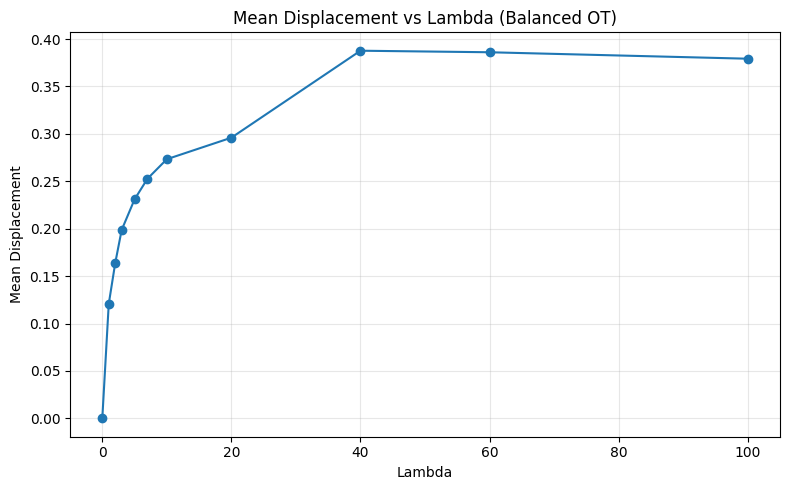

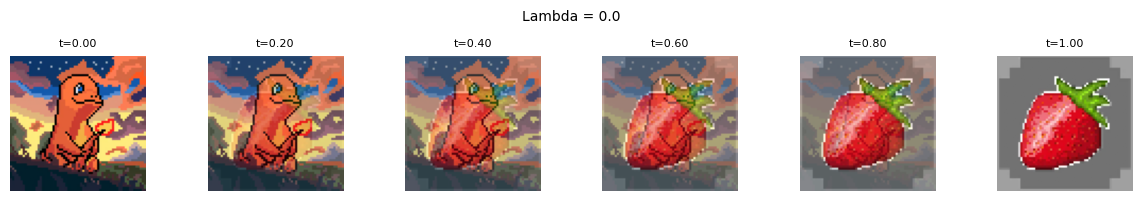

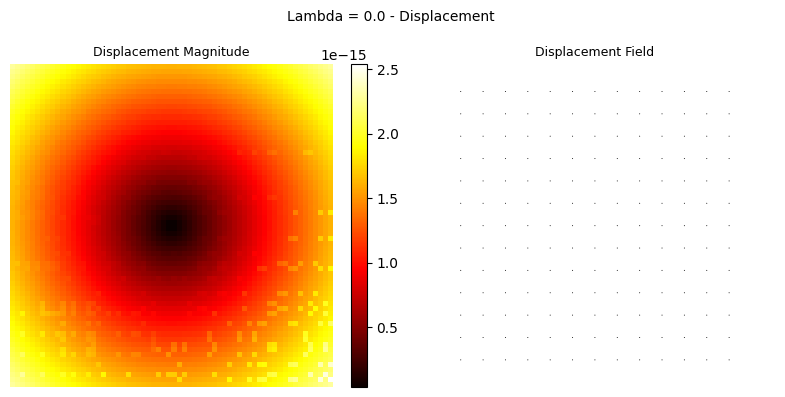

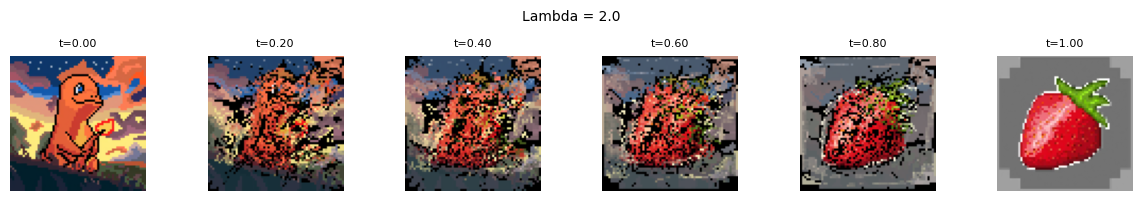

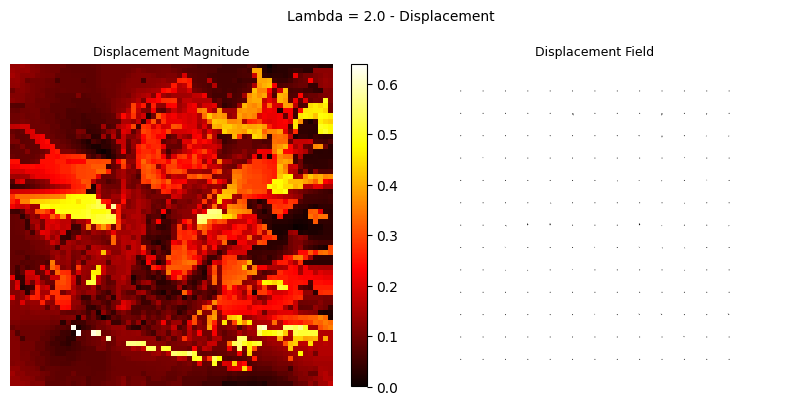

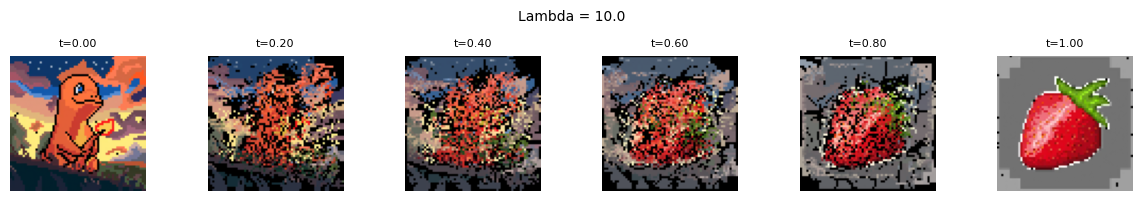

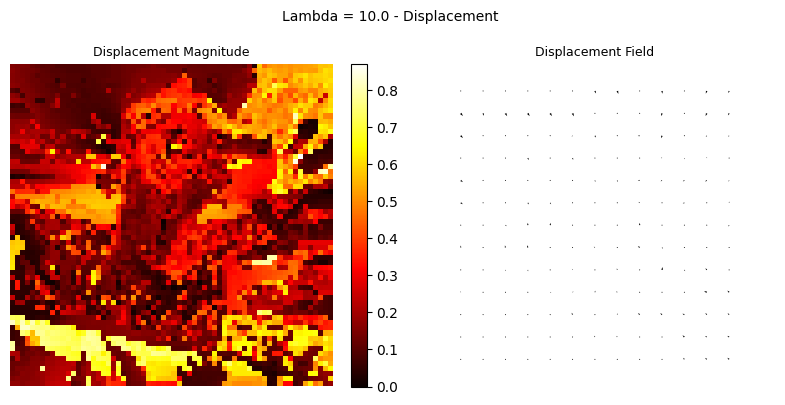

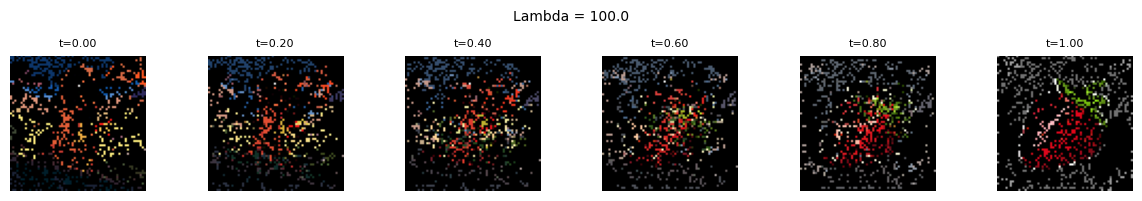

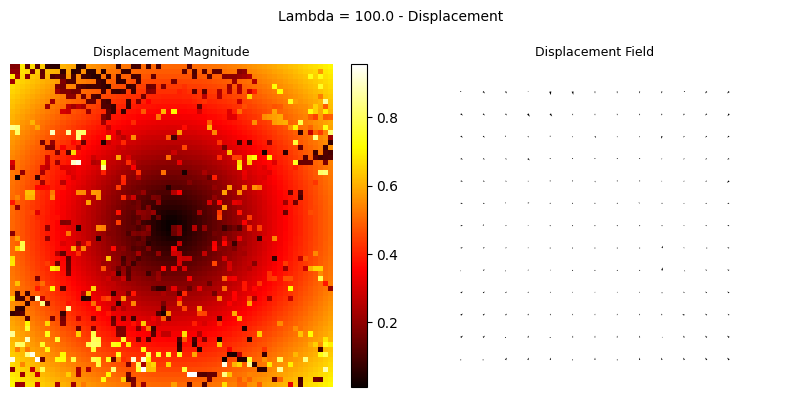

In [ ]:
# --- Study 1: Balanced OT (no epsilon, no splatting) - Vary Lambda ---

print("=" * 80)
print("Study 1: Balanced OT - Vary Lambda")
print("=" * 80)

img1, img2 = load_images()

# Lambda values to test
lambda_values = [0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 40.0, 60.0, 100.0]

study1_results = {}
study1_transport_maps = {}
times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for lambda_val in tqdm(lambda_values, desc="Varying lambda"):
    config = OTConfig(
        resolution=(64, 64),
        blur=0.0,  # No epsilon (balanced OT)
        reach=None,  # Balanced OT
        lambda_color=lambda_val,
        sigma=None  # No splatting
    )
    
    interpolator = OT5DInterpolator(config)
    frames, displacement_field, transport_maps = interpolator.interpolate(
        img1, img2, times, return_plan=True
    )
    
    study1_results[lambda_val] = {
        'frames': frames,
        'displacement_field': displacement_field,
        'mean_displacement': torch.norm(displacement_field, dim=-1).mean().item()
    }
    study1_transport_maps[lambda_val] = transport_maps
    
    mean_disp = study1_results[lambda_val]['mean_displacement']
    print(f"Lambda = {lambda_val:.1f}: Mean displacement = {mean_disp:.4f}")

# Plot results
lambda_vals = list(study1_results.keys())
mean_disps = [study1_results[l]['mean_displacement'] for l in lambda_vals]
plot_mean_displacement_vs_param(lambda_vals, mean_disps, "Lambda", 
                                "Mean Displacement vs Lambda (Balanced OT)")

# Plot sample timelines for a few lambda values
sample_lambdas = [0.0, 2.0, 10.0, 100.0]
for lam in sample_lambdas:
    if lam in study1_results:
        plot_timeline_with_displacement(
            study1_results[lam]['frames'], 
            times, 
            study1_results[lam]['displacement_field'],
            f"Lambda = {lam}"
        )

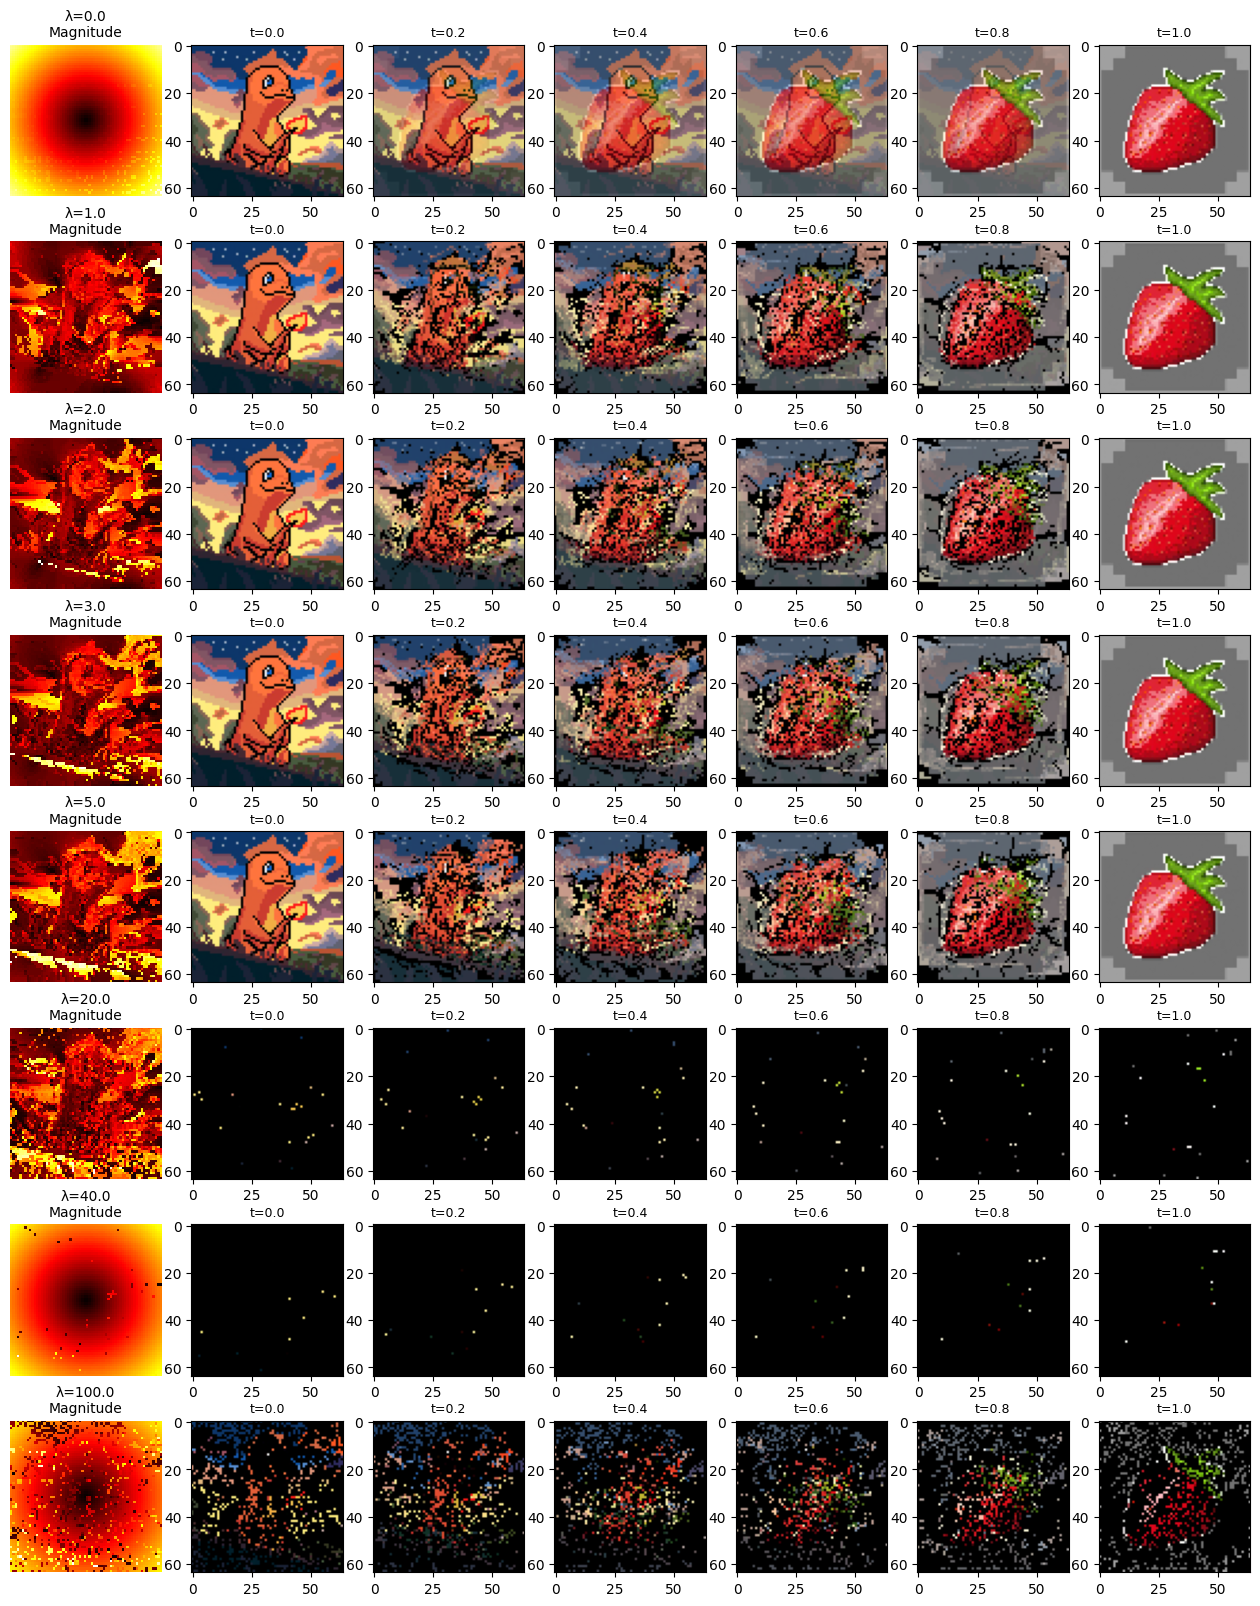

In [ ]:
# Plot stacked timelines with magnitude maps

to_plot_keys = list(study1_results.keys())
# Select first 5 lambdas and those with lambda=20, 40, 100 explicitly
sel_lambdas = to_plot_keys[:5] + [20.0, 40.0, 100.0]
to_plot = {k: study1_results[k] for k in sel_lambdas if k in study1_results}
plot_stacked_timelines_with_magnitude(
    to_plot, 
    times, 
    title="Study 1: Balanced OT - Vary Lambda"
)

Study 2: Vary Rho (Lambda = 2.0)
Loaded source image: ../../data/pixelart/images/salameche.webp
Loaded target image: ../../data/pixelart/images/strawberry.jpg
Loaded images successfully


Varying rho:  12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

Rho = 0.01: Mean displacement = 0.2134


Varying rho:  25%|██▌       | 2/8 [00:02<00:07,  1.27s/it]

Rho = 0.03: Mean displacement = 0.3396


Varying rho:  38%|███▊      | 3/8 [00:12<00:25,  5.15s/it]

Rho = 0.05: Mean displacement = 0.2988


Varying rho:  50%|█████     | 4/8 [00:58<01:26, 21.54s/it]

Rho = 0.10: Mean displacement = 0.2267


Varying rho:  62%|██████▎   | 5/8 [02:21<02:10, 43.46s/it]

Rho = 0.30: Mean displacement = 0.1894


Varying rho:  75%|███████▌  | 6/8 [04:13<02:14, 67.04s/it]

Rho = 0.50: Mean displacement = 0.1929


Varying rho:  88%|████████▊ | 7/8 [06:22<01:27, 87.04s/it]

Rho = 0.70: Mean displacement = 0.1881


Varying rho: 100%|██████████| 8/8 [08:31<00:00, 63.99s/it] 

Rho = 1.00: Mean displacement = 0.1737


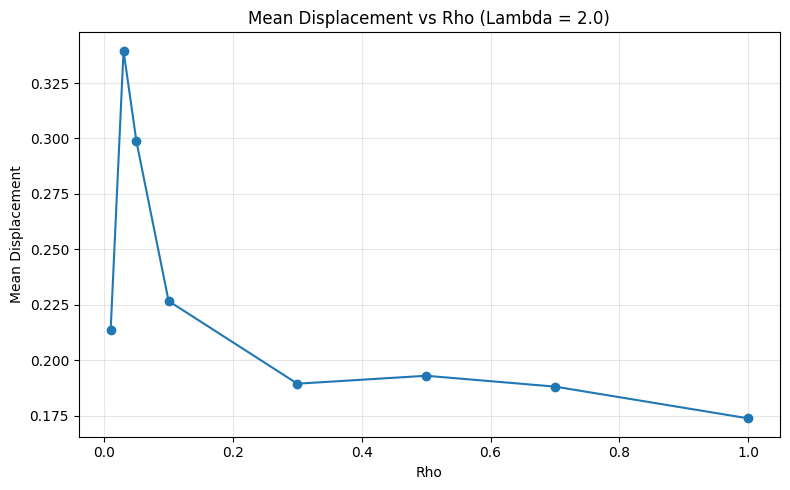

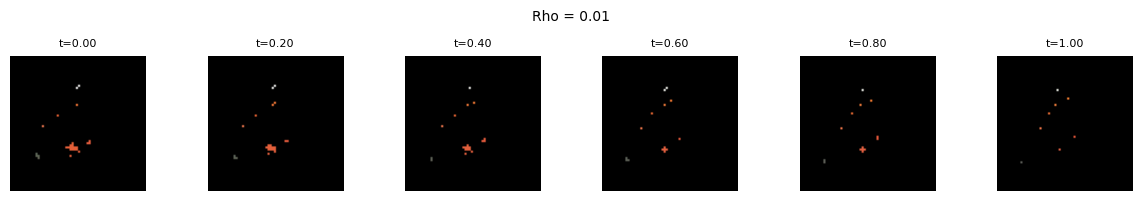

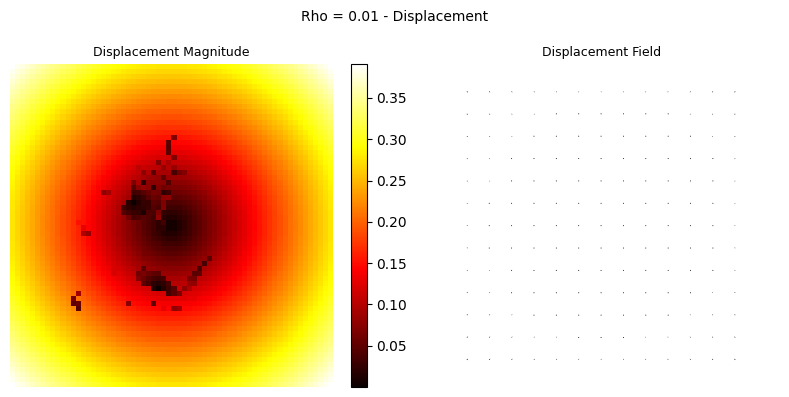

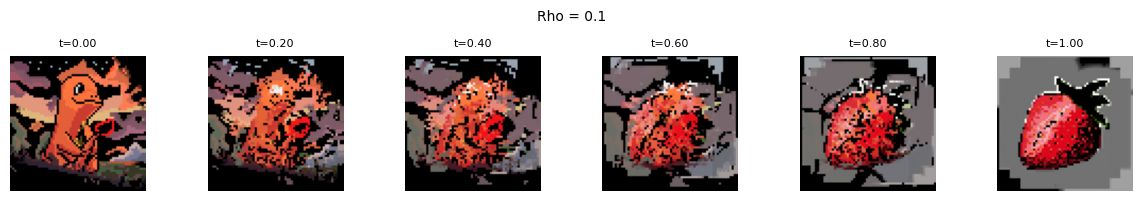

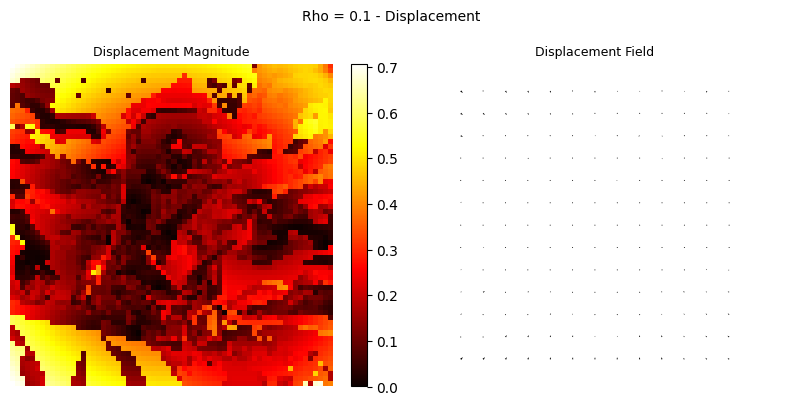

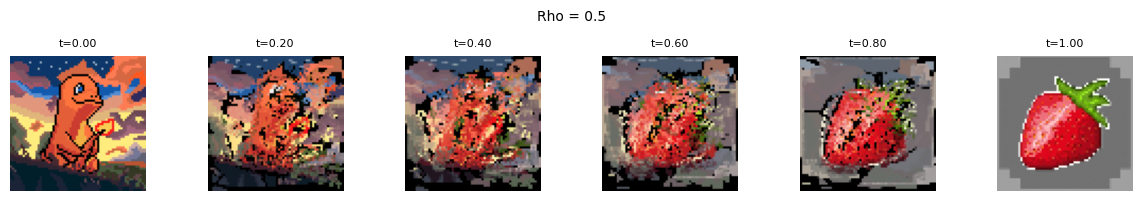

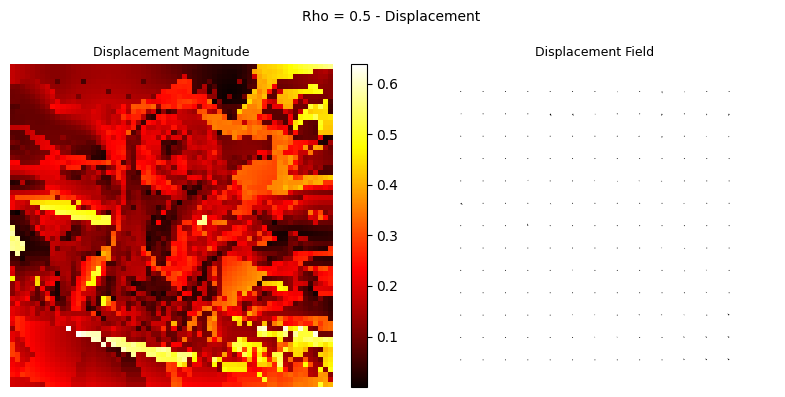

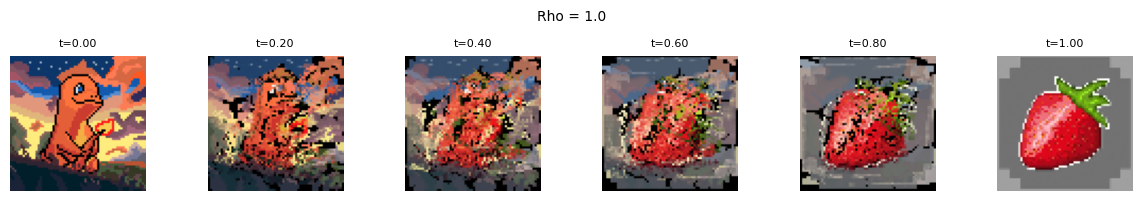

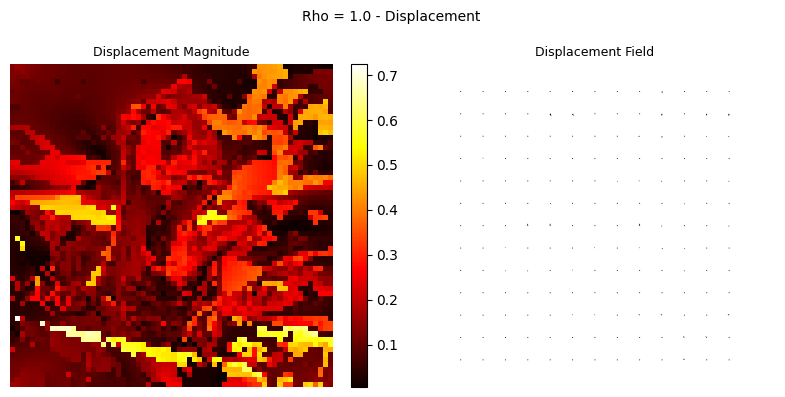

In [ ]:
# --- Study 2: Vary Rho for Lambda = 2.0 ---

print("=" * 80)
print("Study 2: Vary Rho (Lambda = 2.0)")
print("=" * 80)

img1, img2 = load_images()

# Rho values to test
rho_values = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]

study2_results = {}
study2_transport_maps = {}
times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for rho in tqdm(rho_values, desc="Varying rho"):
    config = OTConfig(
        resolution=(64, 64),
        blur=0.01,  # Small epsilon
        reach=rho,
        lambda_color=2.0,
        sigma=None  # No splatting
    )
    
    interpolator = OT5DInterpolator(config)
    frames, displacement_field, transport_maps = interpolator.interpolate(
        img1, img2, times, return_plan=True
    )
    
    study2_results[rho] = {
        'frames': frames,
        'displacement_field': displacement_field,
        'mean_displacement': torch.norm(displacement_field, dim=-1).mean().item()
    }
    study2_transport_maps[rho] = transport_maps
    
    mean_disp = study2_results[rho]['mean_displacement']
    print(f"Rho = {rho:.2f}: Mean displacement = {mean_disp:.4f}")

# Plot results
rho_vals = list(study2_results.keys())
mean_disps = [study2_results[r]['mean_displacement'] for r in rho_vals]
plot_mean_displacement_vs_param(rho_vals, mean_disps, "Rho", 
                                "Mean Displacement vs Rho (Lambda = 2.0)")

# Plot sample timelines
sample_rhos = [0.01, 0.1, 0.5, 1.0]
for rho in sample_rhos:
    if rho in study2_results:
        plot_timeline_with_displacement(
            study2_results[rho]['frames'], 
            times, 
            study2_results[rho]['displacement_field'],
            f"Rho = {rho}"
        )

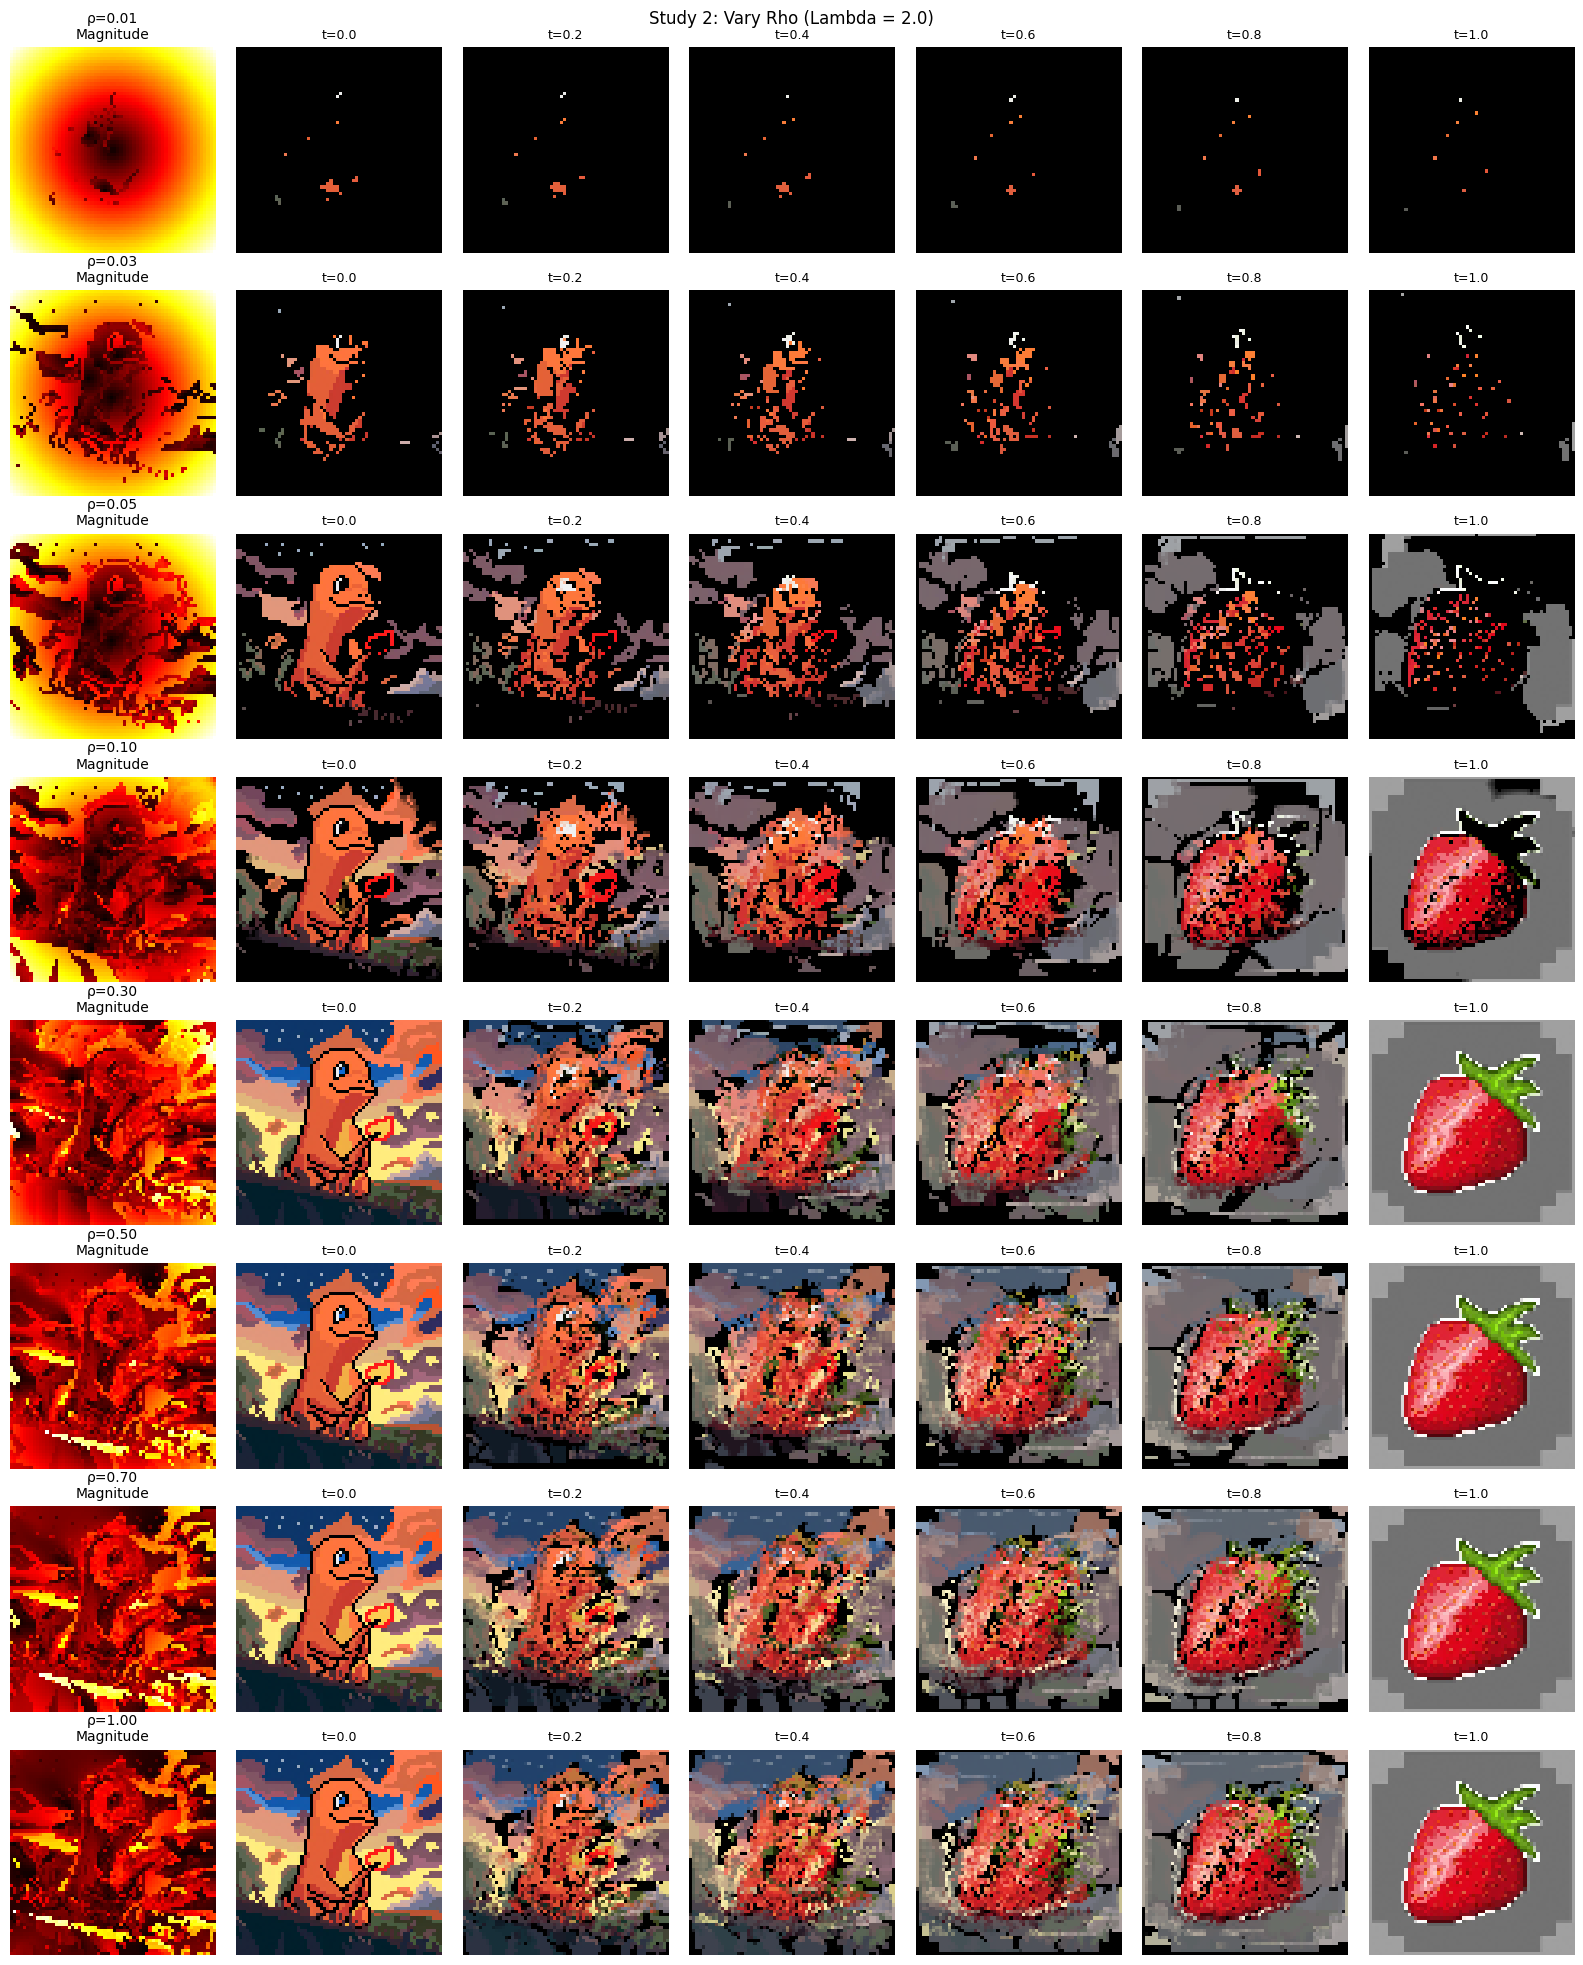

In [ ]:
# Plot stacked timelines with magnitude maps


plot_stacked_timelines_with_magnitude(
    study2_results, 
    times, 
    param_type="rho",
    title="Study 2: Vary Rho (Lambda = 2.0)"
)

In [ ]:
# --- Study 3: Vary Epsilon and Select Epsilon = 0.01 ---

print("=" * 80)
print("Study 3: Vary Epsilon")
print("=" * 80)

img1, img2 = load_images()

# Epsilon values: 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, then log scale
epsilon_values = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1]
# Add log scale values below 0.001
epsilon_values.extend([1e-4, 2e-4, 5e-4, 1e-3])
# Add log scale values above 0.1
epsilon_values.extend([0.2, 0.5, 1.0, 2.0, 5.0, 10.0])
epsilon_values = sorted(epsilon_values)

study3_results = {}
study3_transport_maps = {}
times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for eps in tqdm(epsilon_values, desc="Varying epsilon"):
    config = OTConfig(
        resolution=(64, 64),
        blur=eps,
        reach=0.7,  # Use rho = 0.7
        lambda_color=2.0,
        sigma=None  # No splatting
    )
    
    interpolator = OT5DInterpolator(config)
    frames, displacement_field, transport_maps = interpolator.interpolate(
        img1, img2, times, return_plan=True
    )
    
    study3_results[eps] = {
        'frames': frames,
        'displacement_field': displacement_field
    }
    study3_transport_maps[eps] = transport_maps
    
    print(f"Epsilon = {eps:.4f}: Computed")

# Plot sample timelines for different epsilon values
sample_epsilons = [0.01, 0.02, 0.05, 0.1]
for eps in sample_epsilons:
    if eps in study3_results:
        plot_timeline(study3_results[eps]['frames'], times, 
                     f"Interpolation Timeline (Epsilon = {eps})")

# Select epsilon = 0.01
selected_epsilon = 0.01
print(f"\nSelected epsilon = {selected_epsilon}")

Study 3: Vary Epsilon
Loaded source image: ../../data/pixelart/images/salameche.webp
Loaded target image: ../../data/pixelart/images/strawberry.jpg
Loaded images successfully


Varying epsilon:   6%|▋         | 1/16 [00:01<00:15,  1.02s/it]

Epsilon = 0.0001: Computed


Varying epsilon:  12%|█▎        | 2/16 [00:20<02:43, 11.68s/it]

Epsilon = 0.0002: Computed


Varying epsilon:  19%|█▉        | 3/16 [00:39<03:16, 15.13s/it]

Epsilon = 0.0005: Computed


Varying epsilon:  25%|██▌       | 4/16 [00:59<03:27, 17.27s/it]

Epsilon = 0.0010: Computed


Varying epsilon:  31%|███▏      | 5/16 [02:53<09:30, 51.85s/it]

Epsilon = 0.0100: Computed


Varying epsilon:  38%|███▊      | 6/16 [08:16<24:02, 144.28s/it]

Epsilon = 0.0200: Computed


Varying epsilon:  38%|███▊      | 6/16 [16:07<26:51, 161.17s/it]


KeyboardInterrupt: 

In [ ]:
# Plot stacked timelines with magnitude maps
plot_stacked_timelines_with_magnitude(
    study3_results, 
    times, 
    title="Study 3: Vary Epsilon"
)

In [ ]:
# --- Study 4: Vary Rho with Epsilon = 0.01, Lambda = 2.0, Select Rho = 0.7 ---

print("=" * 80)
print("Study 4: Vary Rho (Epsilon = 0.01, Lambda = 2.0)")
print("=" * 80)

img1, img2 = load_images()

# Rho values to test
rho_values = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]

study4_results = {}
study4_transport_maps = {}
times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for rho in tqdm(rho_values, desc="Varying rho"):
    config = OTConfig(
        resolution=(64, 64),
        blur=0.01,  # Selected epsilon
        reach=rho,
        lambda_color=2.0,
        sigma=None  # No splatting
    )
    
    interpolator = OT5DInterpolator(config)
    frames, displacement_field, transport_maps = interpolator.interpolate(
        img1, img2, times, return_plan=True
    )
    
    study4_results[rho] = {
        'frames': frames,
        'displacement_field': displacement_field,
        'mean_displacement': torch.norm(displacement_field, dim=-1).mean().item()
    }
    study4_transport_maps[rho] = transport_maps
    
    mean_disp = study4_results[rho]['mean_displacement']
    print(f"Rho = {rho:.2f}: Mean displacement = {mean_disp:.4f}")

# Plot results
rho_vals = list(study4_results.keys())
mean_disps = [study4_results[r]['mean_displacement'] for r in rho_vals]
plot_mean_displacement_vs_param(rho_vals, mean_disps, "Rho", 
                                "Mean Displacement vs Rho (Epsilon = 0.01, Lambda = 2.0)")

# Plot sample timelines
sample_rhos = [0.01, 0.1, 0.5, 0.7, 1.0]
for rho in sample_rhos:
    if rho in study4_results:
        plot_timeline_with_displacement(
            study4_results[rho]['frames'], 
            times, 
            study4_results[rho]['displacement_field'],
            f"Rho = {rho}"
        )

# Select rho = 0.7
selected_rho = 0.7
print(f"\nSelected rho = {selected_rho}")

In [ ]:
# --- Study 5: Vary Splatting with All Parameter Combinations ---

print("=" * 80)
print("Study 5: Vary Splatting (Sigma)")
print("=" * 80)

img1, img2 = load_images()

# Parameter values
epsilon_values = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1]
lambda_values = [0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 40.0, 60.0, 100.0]
rho_values = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]
sigma_values = [0.1, 0.25, 0.5, 0.7, 1.0, 1.5, 2.0]

# Use selected values: epsilon = 0.01, lambda = 2.0, rho = 0.7
# But also test variations
study5_results = {}
study5_transport_maps = {}
times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Main study: vary sigma with selected parameters
print("Main study: Vary sigma with epsilon=0.01, lambda=2.0, rho=0.7")
for sigma in tqdm(sigma_values, desc="Varying sigma"):
    config = OTConfig(
        resolution=(64, 64),
        blur=0.01,
        reach=0.7,
        lambda_color=2.0,
        sigma=sigma
    )
    
    interpolator = OT5DInterpolator(config)
    frames, displacement_field, transport_maps = interpolator.interpolate(
        img1, img2, times, return_plan=True
    )
    
    study5_results[('main', sigma)] = {
        'frames': frames,
        'config': {'epsilon': 0.01, 'lambda': 2.0, 'rho': 0.7, 'sigma': sigma}
    }
    study5_transport_maps[('main', sigma)] = transport_maps

# Additional studies: vary other parameters with fixed sigma = 0.5
print("\nAdditional study: Vary epsilon with sigma=0.5, lambda=2.0, rho=0.7")
for eps in tqdm(epsilon_values, desc="Varying epsilon"):
    config = OTConfig(
        resolution=(64, 64),
        blur=eps,
        reach=0.7,
        lambda_color=2.0,
        sigma=0.5
    )
    
    interpolator = OT5DInterpolator(config)
    frames, displacement_field, transport_maps = interpolator.interpolate(
        img1, img2, times, return_plan=True
    )
    
    study5_results[('epsilon', eps)] = {
        'frames': frames,
        'config': {'epsilon': eps, 'lambda': 2.0, 'rho': 0.7, 'sigma': 0.5}
    }
    study5_transport_maps[('epsilon', eps)] = transport_maps

print("\nAdditional study: Vary lambda with sigma=0.5, epsilon=0.01, rho=0.7")
for lambda_val in tqdm(lambda_values, desc="Varying lambda"):
    config = OTConfig(
        resolution=(64, 64),
        blur=0.01,
        reach=0.7,
        lambda_color=lambda_val,
        sigma=0.5
    )
    
    interpolator = OT5DInterpolator(config)
    frames, displacement_field, transport_maps = interpolator.interpolate(
        img1, img2, times, return_plan=True
    )
    
    study5_results[('lambda', lambda_val)] = {
        'frames': frames,
        'config': {'epsilon': 0.01, 'lambda': lambda_val, 'rho': 0.7, 'sigma': 0.5}
    }
    study5_transport_maps[('lambda', lambda_val)] = transport_maps

print("\nAdditional study: Vary rho with sigma=0.5, epsilon=0.01, lambda=2.0")
for rho in tqdm(rho_values, desc="Varying rho"):
    config = OTConfig(
        resolution=(64, 64),
        blur=0.01,
        reach=rho,
        lambda_color=2.0,
        sigma=0.5
    )
    
    interpolator = OT5DInterpolator(config)
    frames, displacement_field, transport_maps = interpolator.interpolate(
        img1, img2, times, return_plan=True
    )
    
    study5_results[('rho', rho)] = {
        'frames': frames,
        'config': {'epsilon': 0.01, 'lambda': 2.0, 'rho': rho, 'sigma': 0.5}
    }
    study5_transport_maps[('rho', rho)] = transport_maps

# Plot main study results (vary sigma)
print("\nPlotting main study results (vary sigma)...")
main_sigmas = [s for k, s in study5_results.keys() if k == 'main']
main_sigmas = sorted(main_sigmas)
for sigma in main_sigmas[:5]:  # Plot first 5
    if ('main', sigma) in study5_results:
        plot_timeline(study5_results[('main', sigma)]['frames'], times,
                     f"Interpolation Timeline (Sigma = {sigma})")

In [ ]:
# --- Summary ---
print("\n" + "=" * 80)
print("All studies completed!")
print("=" * 80)
print(f"Selected epsilon: {selected_epsilon}")
print(f"Selected rho: {selected_rho}")